### 이미지 증강

#### 파이토치와 텐서플로우 등의 이미지에 대한 텐서처리 방법이 다름
- PyTorch는 기본이 (C, H, W)
- NumPy / TensorFlow / Matplotlib은 기본이 (H, W, C)
- 이므로 plt에 적용하기 위해서는 .permute(1, 2, 0)  # (C,H,W) -> (H,W,C)로 순서를 바꿔야 함

torch.Size([3, 512, 512])
torch.Size([512, 512, 3])


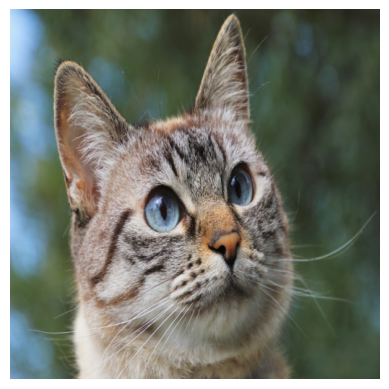

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor() # 이것 때문에 파이토치 텐서로 변환 됨
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
print(transformed_image.shape)
img = transformed_image.permute(1, 2, 0)  # (C,H,W) -> (H,W,C)로 순서를 바꾸다.
# PyTorch는 기본이 (C, H, W), NumPy / TensorFlow / Matplotlib은 기본이 (H, W, C)
print(img.shape) # (H,W,C)
plt.imshow(img)
plt.axis("off")
plt.show()

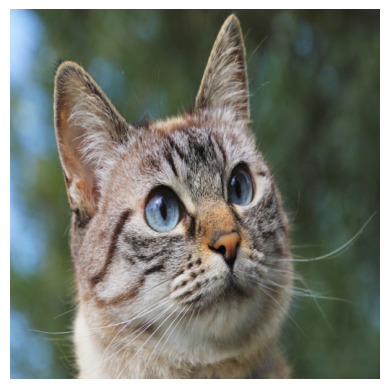

In [3]:
# 텐서로 전환하지 않으면 .permute(1, 2, 0)  # (C,H,W) -> (H,W,C)로 바꾸지 않아도 됨
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

from PIL import Image
from torchvision import transforms


transform = transforms.Compose(
    [
        transforms.Resize(size=(512, 512)),
       # transforms.ToTensor() # 이것 때문에 파이토치 텐서로 변환 됨
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)
plt.axis("off")
plt.show()

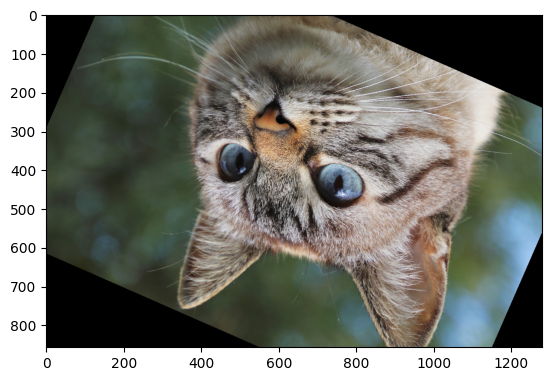

In [9]:
# 회전 및 대칭: 무작위로 -30 ~ 30로 회전하면서 수평 대칭과 수직 대칭을 50% 확률 적용

transform = transforms.Compose(
    [
        transforms.RandomRotation(degrees=30, expand=False, center=None),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image) 
plt.imshow(transformed_image)

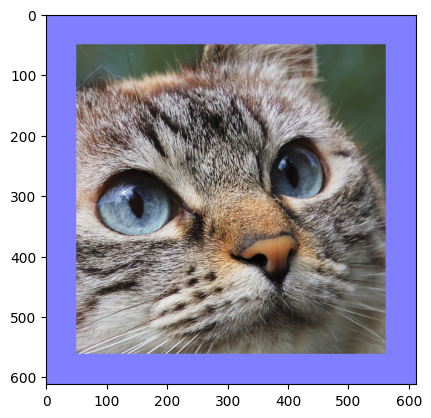

In [11]:
# 4.18  무작위 자르기 및 패딩 

transform = transforms.Compose(
    [
        transforms.RandomCrop(size=(512, 512)),
        transforms.Pad(padding=50, fill=(127, 127, 255), padding_mode="constant")
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)

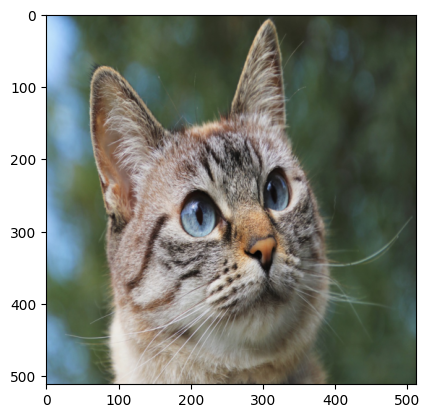

In [13]:
# 크기 조정 예제 4.19
transform = transforms.Compose(
    [
        transforms.Resize(size=(512, 512))
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)

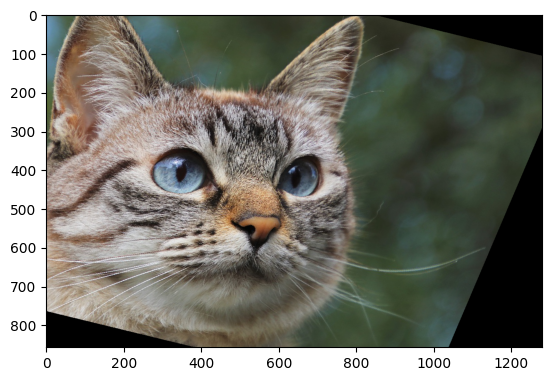

In [15]:
# 아핀 변환 
transform = transforms.Compose(
    [
        transforms.RandomAffine(
            degrees=15, translate=(0.2, 0.2),
            scale=(0.8, 1.2), shear=15
        )
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)

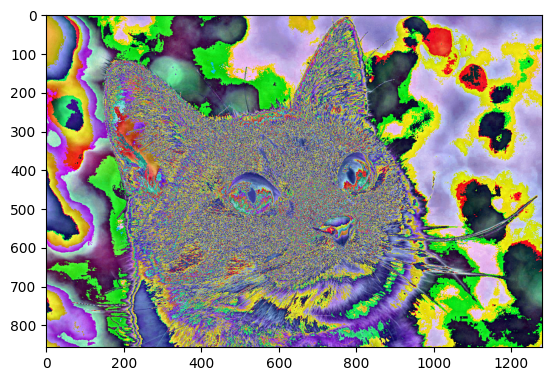

In [17]:
# 색상 변환 및 정규화

transform = transforms.Compose(
    [
        transforms.ColorJitter(
            brightness=0.3, contrast=0.3,
            saturation=0.3, hue=0.3
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        ),
        transforms.ToPILImage()
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)

(857, 1280, 3) uint8


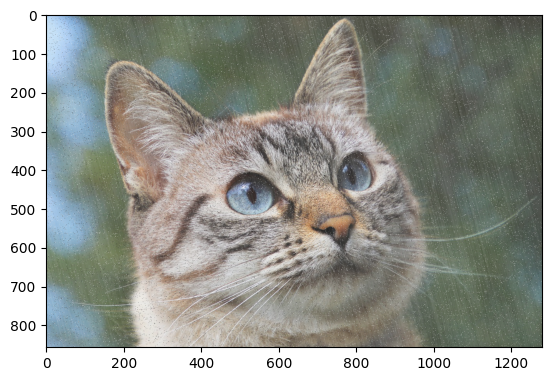

In [19]:
# 노이즈 기반 이미지 증강
# - Salt & Pepper 노이즈
# - Rain(빗방울) 효과

import numpy as np
np.bool = np.bool_ # Deprecated 오류 방지
from PIL import Image
from torchvision import transforms
from imgaug import augmenters as iaa


class IaaTransforms:
    def __init__(self):
        self.seq = iaa.Sequential([
            iaa.SaltAndPepper(p=(0.03, 0.07)), # Salt & Pepper 노이즈
            iaa.Rain(speed=(0.3, 0.7)) # 빗방울 노이즈
        ])
    
    def __call__(self, images): 
        images = np.array(images)
        print(images.shape, images.dtype)
        augmented = self.seq.augment_image(images)
        return Image.fromarray(augmented)


transform = transforms.Compose([
    IaaTransforms()
])

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)

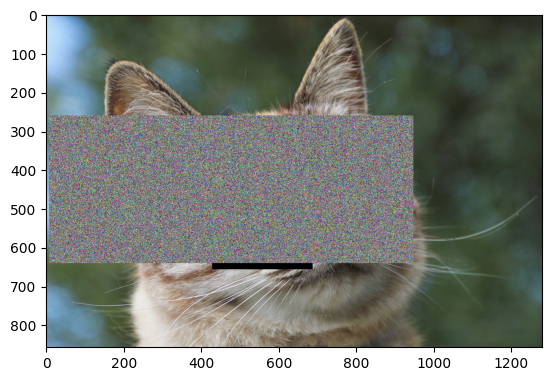

In [21]:
## 컷아웃 및 무작위 자르기

# RandomErasing은 Tensor 전용이라서,
# PIL → Tensor → (증강) → PIL 로 왕복

transform = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.RandomErasing(p=1.0, value=0),
    transforms.RandomErasing(p=1.0, value='random'),
    transforms.ToPILImage() # 다시 PIL로 황복 변환
])

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)

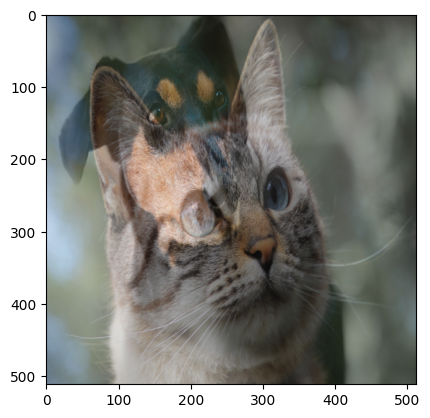

In [23]:
# 혼합 및 컷믹스
# 혼합 두개 이상 이미지를 혼합(Blending)하여 새로운 이미지를 생성하는 방법 -> 다중 레이블 문제에서도 견고한 모델
# 컷믹스는 패치 위에 새로운 패티를 덮어 쉬워 비교적 자연스러운 이미지를 구성함

# 혼합
class Mixup:
    def __init__(self, target, scale, alpha=0.5, beta=0.5):
        self.target = target
        self.scale = scale
        self.alpha = alpha
        self.beta = beta

    def __call__(self, image):
        image = np.array(image)
        target = self.target.resize(self.scale)
        target = np.array(target)
        mix_image = image * self.alpha + target * self.beta
        return Image.fromarray(mix_image.astype(np.uint8))


transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        Mixup(
            target=Image.open("../datasets/images/dog.jpg"),
            scale=(512, 512),
            alpha=0.5,
            beta=0.5
        )
    ]
)

image = Image.open("../datasets/images/cat.jpg")
transformed_image = transform(image)
plt.imshow(transformed_image)